# 로지스틱+RFECV 전진처리

nan-value filled
MonthlyRevenue : 50887, 삭제된 수 : 1
MonthlyMinutes : 50883, 삭제된 수 : 4
TotalRecurringCharge : 50874, 삭제된 수 : 9
DirectorAssistedCalls : 50874, 삭제된 수 : 0
OverageMinutes : 50870, 삭제된 수 : 4
RoamingCalls : 50862, 삭제된 수 : 8
PercChangeMinutes : 50860, 삭제된 수 : 2
DroppedCalls : 50856, 삭제된 수 : 4
BlockedCalls : 50852, 삭제된 수 : 4
UnansweredCalls : 50842, 삭제된 수 : 10
CustomerCareCalls : 50840, 삭제된 수 : 2
ThreewayCalls : 50836, 삭제된 수 : 4
ReceivedCalls : 50830, 삭제된 수 : 6
OutboundCalls : 50827, 삭제된 수 : 3
InboundCalls : 50823, 삭제된 수 : 4
PeakCallsInOut : 50821, 삭제된 수 : 2
OffPeakCallsInOut : 50806, 삭제된 수 : 15
DroppedBlockedCalls : 50792, 삭제된 수 : 14
CallForwardingCalls : 50779, 삭제된 수 : 13
CallWaitingCalls : 50779, 삭제된 수 : 0
MonthsInService : 50778, 삭제된 수 : 1
UniqueSubs : 50777, 삭제된 수 : 1
ActiveSubs : 50777, 삭제된 수 : 0
Handsets : 50773, 삭제된 수 : 4
HandsetModels : 50773, 삭제된 수 : 0
CurrentEquipmentDays : 50768, 삭제된 수 : 5
RetentionCalls : 50634, 삭제된 수 : 134
RetentionOffersAccepted : 50634, 삭제된 수 : 0


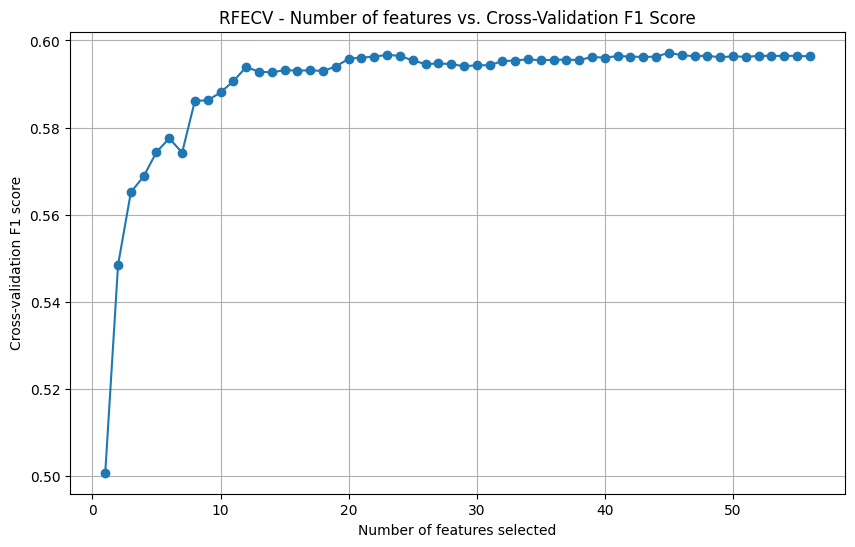

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE  # SMOTE import
import numpy as np
import pre_data as eda
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = eda.preprocessing(data)

# 1. 데이터 전처리 (범주형 데이터 변환 및 스케일링)
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 타겟 변수 및 독립 변수 설정
X = convert_data.drop('Churn', axis=1)
y = convert_data['Churn'].astype(int)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 인덱스 재설정 (reset_index)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# SMOTE 적용 (훈련 데이터셋에 대해서만 적용)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 로지스틱 회귀 모델 선언 (SMOTE 적용 후 클래스 불균형 해결 필요 없음)
model = LogisticRegression(solver='liblinear',penalty='l2', max_iter=1000)

# RFECV를 사용한 피처 선택
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(10),
    scoring='f1',
    n_jobs=-1
)

# 피처 선택 수행
rfecv.fit(X_train_resampled, y_train_resampled)

# 선택된 피처
selected_features = X_train.columns[rfecv.support_]
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {list(selected_features)}")

# 선택된 피처로 데이터셋 구성
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# SMOTE로 재샘플링된 데이터로 학습
X_train_resampled_selected = X_train_resampled[selected_features]

# 최종 모델 학습 및 평가
model.fit(X_train_resampled_selected, y_train_resampled)
y_pred_class = model.predict(X_test_selected)

# 최종 성능 평가
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

# 최종 평가 결과 출력
print("\nFinal Model Performance with SMOTE:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# 교차 검증 과정의 성능 지표 그래프 그리기
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation F1 score")
plt.title("RFECV - Number of features vs. Cross-Validation F1 Score")

# 각 단계별 선택된 피처 수
num_features = np.arange(1, len(rfecv.cv_results_['mean_test_score']) + 1)

# 평균 교차 검증 점수
mean_test_scores = rfecv.cv_results_['mean_test_score']

# 그래프 그리기
plt.plot(num_features, mean_test_scores, marker='o')
plt.grid(True)
plt.show()


Optimal number of features: 47
Selected features: ['CustomerID', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'BuysViaMailOrder', 'RespondsToMailOffers', 'HasCreditCard', 'RetentionOffersAccepted', 'NewCellphoneUser', 'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGroup', 'AdjustmentsToCreditRating', 'HandsetPrice', 'MadeCallToRetentionTeam', 'CreditRating', 'MaritalStatus']

Final Model Performance with SMOTE:
Accuracy: 0.57933875

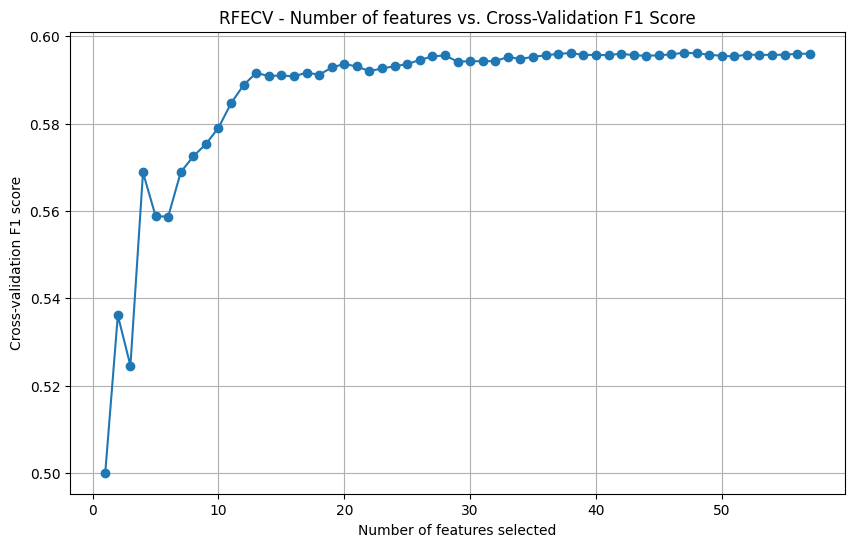

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import pre_data as eda

# 데이터 로드 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = data.dropna()

# 1. 데이터 전처리 (범주형 데이터 변환 및 스케일링)
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 타겟 변수 및 독립 변수 설정
X = convert_data.drop('Churn', axis=1)
y = convert_data['Churn'].astype(int)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 인덱스 재설정 (reset_index)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 로지스틱 회귀 모델 선언
model = LogisticRegression(solver='liblinear', penalty='l2', max_iter=1000)

# 파이프라인을 사용하여 SMOTE 및 RFECV 적용
pipeline = make_pipeline(
    SMOTE(random_state=42),  # SMOTE를 교차 검증 내에서만 적용
    StandardScaler(),  # SMOTE 적용 후 다시 스케일링
    RFECV(
        estimator=model,
        step=1,  # 한 번에 하나의 피처씩 제거
        cv=StratifiedKFold(10),  # 10-fold Stratified KFold 사용
        scoring='f1',  # F1 스코어를 기준으로 피처 선택
        n_jobs=-1  # 모든 코어를 사용
    )
)

# 파이프라인으로 피처 선택 및 학습 수행
pipeline.fit(X_train, y_train)

# 선택된 피처 확인
rfecv = pipeline.named_steps['rfecv']
selected_features = X_train.columns[rfecv.support_]
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {list(selected_features)}")

# 최종 모델 학습 및 평가 (파이프라인을 사용한 예측)
y_pred_class = pipeline.predict(X_test)

# 최종 성능 평가
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

# 최종 평가 결과 출력
print("\nFinal Model Performance with SMOTE:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# 교차 검증 과정의 성능 지표 그래프 그리기
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation F1 score")
plt.title("RFECV - Number of features vs. Cross-Validation F1 Score")

# 각 단계별 선택된 피처 수
num_features = np.arange(1, len(rfecv.cv_results_['mean_test_score']) + 1)

# 평균 교차 검증 점수
mean_test_scores = rfecv.cv_results_['mean_test_score']

# 그래프 그리기
plt.plot(num_features, mean_test_scores, marker='o')
plt.grid(True)
plt.show()


nan-value filled
MonthlyRevenue : 50887, 삭제된 수 : 1
MonthlyMinutes : 50883, 삭제된 수 : 4
TotalRecurringCharge : 50874, 삭제된 수 : 9
DirectorAssistedCalls : 50874, 삭제된 수 : 0
OverageMinutes : 50870, 삭제된 수 : 4
RoamingCalls : 50862, 삭제된 수 : 8
PercChangeMinutes : 50860, 삭제된 수 : 2
DroppedCalls : 50856, 삭제된 수 : 4
BlockedCalls : 50852, 삭제된 수 : 4
UnansweredCalls : 50842, 삭제된 수 : 10
CustomerCareCalls : 50840, 삭제된 수 : 2
ThreewayCalls : 50836, 삭제된 수 : 4
ReceivedCalls : 50830, 삭제된 수 : 6
OutboundCalls : 50827, 삭제된 수 : 3
InboundCalls : 50823, 삭제된 수 : 4
PeakCallsInOut : 50821, 삭제된 수 : 2
OffPeakCallsInOut : 50806, 삭제된 수 : 15
DroppedBlockedCalls : 50792, 삭제된 수 : 14
CallForwardingCalls : 50779, 삭제된 수 : 13
CallWaitingCalls : 50779, 삭제된 수 : 0
MonthsInService : 50778, 삭제된 수 : 1
UniqueSubs : 50777, 삭제된 수 : 1
ActiveSubs : 50777, 삭제된 수 : 0
Handsets : 50773, 삭제된 수 : 4
HandsetModels : 50773, 삭제된 수 : 0
CurrentEquipmentDays : 50768, 삭제된 수 : 5
RetentionCalls : 50634, 삭제된 수 : 134
RetentionOffersAccepted : 50634, 삭제된 수 : 0


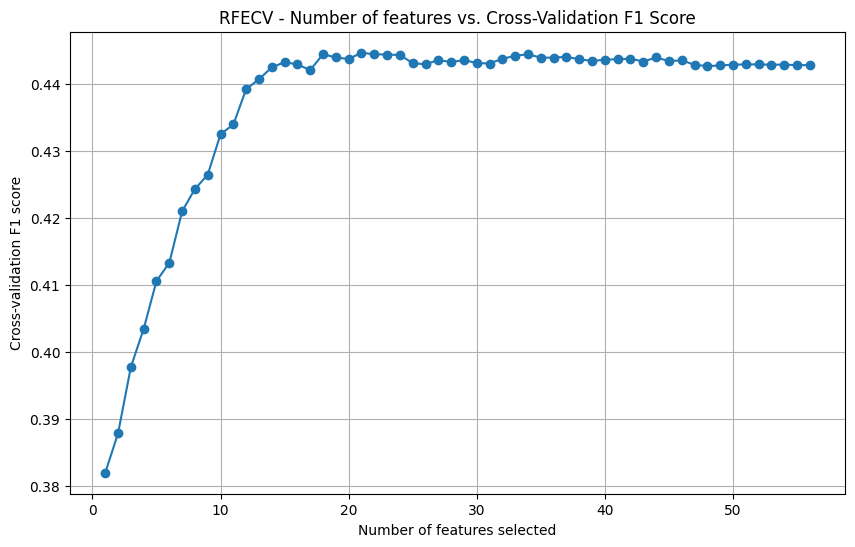

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
import numpy as np
import pre_data as eda
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
data = pd.read_csv('./data/train.csv', encoding='cp949')
preprocessed_data = eda.preprocessing(data)

# 1. 데이터 전처리 (범주형 데이터 변환 및 스케일링)
object_columns = preprocessed_data.select_dtypes(include=['object'])
convert_data, _ = eda.convert_category_into_integer(preprocessed_data, object_columns)

# 타겟 변수 및 독립 변수 설정
X = convert_data.drop('Churn', axis=1)
y = convert_data['Churn'].astype(int)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 인덱스 재설정 (reset_index)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 로지스틱 회귀 모델 선언 (클래스 불균형 해결을 위해 class_weight='balanced' 사용)
model = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)

# RFECV를 사용한 피처 선택
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=-1
)

# 피처 선택 수행
rfecv.fit(X_train, y_train)

# 선택된 피처
selected_features = X_train.columns[rfecv.support_]
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {list(selected_features)}")

# 선택된 피처로 데이터셋 구성
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 최종 모델 학습 및 평가
model.fit(X_train_selected, y_train)
y_pred_class = model.predict(X_test_selected)

# 최종 성능 평가
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

# 최종 평가 결과 출력
print("\nFinal Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# 교차 검증 과정의 성능 지표 그래프 그리기
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation F1 score")
plt.title("RFECV - Number of features vs. Cross-Validation F1 Score")

# 각 단계별 선택된 피처 수
num_features = np.arange(1, len(rfecv.cv_results_['mean_test_score']) + 1)

# 평균 교차 검증 점수
mean_test_scores = rfecv.cv_results_['mean_test_score']

# 그래프 그리기
plt.plot(num_features, mean_test_scores, marker='o')
plt.grid(True)
plt.show()
